<h1 align='center'><u>Spam Detection HW-File1</u></h1>

<font color = 'red' size = 4 >**Read complete instructions before starting the HW** </font>


# Q1: Load the dataset  (1 Point)

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe. 

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





In [ ]:
!pip install feature-engine -qq

     |████████████████████████████████| 205 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 28.6 MB/s 


In [ ]:
!pip install -U spacy -qq

     |████████████████████████████████| 6.0 MB 4.5 MB/s 
     |████████████████████████████████| 628 kB 10.9 MB/s 
     |████████████████████████████████| 451 kB 39.4 MB/s 
     |████████████████████████████████| 10.1 MB 31.2 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 181 kB 40.3 MB/s 


In [ ]:
!python -m spacy download 'en_core_web_sm' -qq

     |████████████████████████████████| 13.9 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install pyspellchecker -qq

     |████████████████████████████████| 2.7 MB 5.1 MB/s 


In [ ]:
from pathlib import Path
from google.colab import drive
import sys
drive.mount('/content/drive')
data_folder = Path('/content/drive/MyDrive/Lec4-SentimentAnalysis/HW3/data')

Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/NLP/custom_functions')

In [ ]:
model_folder = Path('/content/drive/MyDrive/NLP/models')

In [ ]:
# Import Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from plot_learning_curve import plot_learning_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from  sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from featurizer import ManualFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import custom_preprocessor as cp
import pandas as pd
import numpy as np
import spacy
import joblib

In [ ]:
df = pd.read_csv(data_folder / 'spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Remove unnecessary columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Rename columns as label and message
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Find % ham amd spam in the data.
percent = df['label'].value_counts(normalize=True)*100
pd.DataFrame({"percentage":percent})

,percentage
ham,86.593683
spam,13.406317


# Q2 : Provide the metric for evaluating model (1 Point)
As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

**Answer:**
> *In spam detection, if an important email were marked as spam (which is positive 
in this case) when it actually isn’t, this could be disastrous it would be missed. Therefore, it would be more important to control for, or prevent, false positives, since it would be better to have spam in inbox than it would be to have an important email in spam. As the emphasis is on controlling for false positives, its better to rely on precision. Also since this is a highly imbalanced dataset, precision is the chosen primary evaluation criterion and roc_auc is used as supporting evaluation criterion*

# Q3 : Classification Pipelines (18 Points)

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model. 

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

**Use a smaller subset of dataset (recommended 40 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on complete data.**

**Requirements:** 

1. You will use XgBoost model for the classification. You will need to tune the **XGBoost for imbalanced dataset** (If you have never used XGBoost before , here is the link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.). 

4. Think carefully about teh pre-processing you will do.

Tip: <font color = 'red'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn: 

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





In [ ]:
# load spacy model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Sampled 80% of the data w/o replacement
df_frac = df.sample(frac=0.8, random_state=42)

In [ ]:
# Sampled 40% each for train and test from abv 80% w/o replacement thereby avoiding data leakage
df_train = df_frac.sample(frac=0.5, replace=False, random_state=42)
df_test = df_frac.drop(df_train.index)

In [ ]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 3181 to 1328
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    2229 non-null   object
 1   message  2229 non-null   object
dtypes: object(2)
memory usage: 52.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 944 to 3186
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    2229 non-null   object
 1   message  2229 non-null   object
dtypes: object(2)
memory usage: 52.2+ KB


In [ ]:
# Encode labels as 0 and 1
le = LabelEncoder()
le.fit(df_train['label'])

df_train['label_encoded'] = le.transform(df_train['label'])
df_test['label_encoded'] = le.transform(df_test['label'])

In [ ]:
df_train.head()

,label,message,label_encoded
3181,ham,"My Parents, My Kidz, My Friends n My Colleague...",0
4834,ham,"OH RITE. WELL IM WITH MY BEST MATE PETE, WHO I...",0
2042,ham,"Me not waking up until 4 in the afternoon, sup",0
3064,ham,"Sounds good, keep me posted",0
2885,ham,No probs hon! How u doinat the mo?,0


In [ ]:
df_test.head()

,label,message,label_encoded
944,ham,I sent my scores to sophas and i had to do sec...,0
1044,spam,We know someone who you know that fancies you....,1
2484,ham,Only if you promise your getting out as SOON a...,0
812,spam,Congratulations ur awarded either å£500 of CD ...,1
2973,ham,"I'll text carlos and let you know, hang on",0


In [ ]:
df_frac['label'].value_counts()

ham     3868
spam     590
Name: label, dtype: int64

In [ ]:
df_train['label'].value_counts()

ham     1929
spam     300
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

ham     1939
spam     290
Name: label, dtype: int64

In [ ]:
X_train, y_train, X_test, y_test = df_train['message'].values, df_train['label_encoded'].values, df_test['message'].values, df_test['label_encoded'].values

In [ ]:
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (2229,) y_train: (2229,)
X_test: (2229,) y_test: (2229,)


Lets analyze following 3 pipelines
- Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline
- Feature Engineering + ML Model pipeline
- Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline



**1. Data Preprocessing + Sparse Embeddings + ML Model pipeline**

* Used TF_IDF vectorizer for sparse embeddings
* Used Weighted XGBoost Classifier as ML Model to address class imbalance

In [ ]:
# Change all words to lowercase
# Remove stop words, punctuations, URLs
# Lammetize words
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', lower=True, remove_stop=True, remove_punct=True, remove_url=True, lammetize=True).transform(X_train)

In [ ]:
classifier_1 = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ('classifier', XGBClassifier()),])

In [ ]:
weights    = [1, 10, 25, 50, 75, 99, 100, 1000]

param_dist = {
              "classifier__max_depth": [2,3,4,5,6],
              "classifier__learning_rate":[0.01,0.02,0.03,0.05,0.1,0.3,0.5],
              "classifier__reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
              "classifier__gamma":[i/10.0 for i in range(0,5)],
              "classifier__n_estimators":[100,500,700,1000],
              "classifier__scale_pos_weight":weights,
              'classifier__max_delta_step': range(1,10,1),
              'vectorizer__ngram_range': ((1, 1), (1, 2), (1,3)),
              'vectorizer__max_features': [None, 500, 800, 1000, 1500, 2000],
              'vectorizer__max_df': [0.8, 0.6, 0.4, 0.2]
              }

In [ ]:
randomized_classifier_1 = RandomizedSearchCV(estimator=classifier_1, param_distributions=param_dist, cv = 5, scoring="precision", n_jobs=-1)

In [ ]:
randomized_classifier_1.fit(X_train_cleaned, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(token_pattern='[\\S]+')),
                                             ('classifier', XGBClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__gamma': [0.0, 0.1, 0.2,
                                                              0.3, 0.4],
                                        'classifier__learning_rate': [0.01,
                                                                      0.02,
                                                                      0.03,
                                                                      0.05, 0.1,
                                                                      0.3,
                                                                      0.5],
                                        'classifier__max_delta_step': range(1, 10),
                       

In [ ]:
print("Best cross-validation score: {:.2f}".format(randomized_classifier_1.best_score_))
print("\nBest parameters: ", randomized_classifier_1.best_params_)
print("\nBest Estimator ", randomized_classifier_1.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 800, 'vectorizer__max_df': 0.6, 'classifier__scale_pos_weight': 1, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 100, 'classifier__max_depth': 2, 'classifier__max_delta_step': 8, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.2}

Best Estimator  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.6, max_features=800,
                                 token_pattern='[\\S]+')),
                ('classifier',
                 XGBClassifier(gamma=0.2, learning_rate=0.03, max_delta_step=8,
                               max_depth=2, reg_alpha=1))])


In [ ]:
file_model_sparse_embed = model_folder / 'spam_sparse_embed_model.pkl'

In [ ]:
joblib.dump(randomized_classifier_1.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/NLP/models/spam_sparse_embed_model.pkl']

In [ ]:
# load the saved model
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

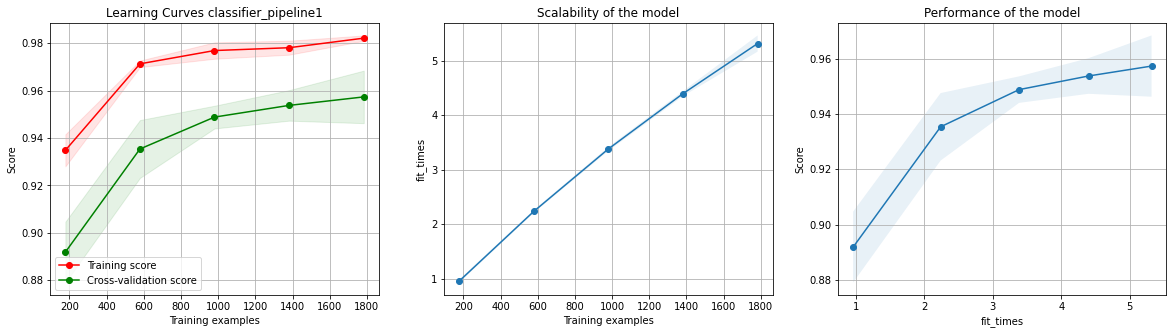

In [ ]:
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_pipeline1', X_train_cleaned, y_train)

In [ ]:
# Precision on Train data set
print('Precision on train set is {:.4f}'.format(loaded_model_sparse_embed.score(X_train_cleaned, y_train)))

Precision on train set is 0.9843


#### Evaluate model on test datset

In [ ]:
def sparseEmbeddingsPipeline(text):
    X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', lower=True, remove_stop=True, remove_punct=True, remove_url=True, lammetize=True).transform(text)
    predictions = loaded_model_sparse_embed.predict(X_test_cleaned)
    return predictions

In [ ]:
y_test_pred = sparseEmbeddingsPipeline(X_test)

In [ ]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1939
           1       0.96      0.75      0.84       290

    accuracy                           0.96      2229
   macro avg       0.96      0.87      0.91      2229
weighted avg       0.96      0.96      0.96      2229



In [ ]:
print('Precision score on test set is {:.4f}'.format(precision_score(y_test, y_test_pred)))

Precision score on test set is 0.9559


In [ ]:
print('ROC_AUC is {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

ROC_AUC is 0.8716


From the learning curve, we infer that Sparse embeddings pipeline seem to perform decently in learning the true relationship with increase in sample size which tells us that spammers tend to use some unique words compared to non-spammers and vice versa. Precision on train set is 0.9843 and test set is 0.9559 whereas auc is 0.8716. 






**Feature Engineering + ML Model pipeline**

In [ ]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [ ]:
X_train_features, feature_names  = featurizer.fit_transform(X_train)

To distinguish spam from non-spam messages have added additional features as follows in featurizer file
* count_words_with_all_capitals - For promotional offers to gain attention, spammers might use capitalized words
* symbols_count - symbol pos tags are used to capture symbols. Spammers tend to use exclammations as terminators or currency symbols. Similarly non-spammers might use emoticons as casual messaging
* count_misspelled - Can be attributes of both spammers and non-spammers but this is an important attribute as well



In [ ]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'count_mispelled',
 'count_words_with_all_capitals',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'symbols_count',
 'ner']

In [ ]:
weights    = [1, 10, 25, 50, 75, 99, 100, 1000]

param_dist = {
              "classifier__max_depth": [2,3,4,5,6],
              "classifier__learning_rate":[0.01,0.02,0.03,0.05,0.1,0.3,0.5],
              "classifier__reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
              "classifier__gamma":[i/10.0 for i in range(0,5)],
              "classifier__n_estimators":[100,500,700,1000],
              "classifier__scale_pos_weight":weights,
              'classifier__max_delta_step': range(1,10,1)
              }

In [ ]:
classifier_1b = Pipeline([('classifier', XGBClassifier()),])

In [ ]:
randomized_classifier_1b = RandomizedSearchCV(estimator=classifier_1b, param_distributions=param_dist, cv = 5, scoring="precision", n_jobs=-1)

In [ ]:
randomized_classifier_1b.fit(X_train_features, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier', XGBClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__gamma': [0.0, 0.1, 0.2,
                                                              0.3, 0.4],
                                        'classifier__learning_rate': [0.01,
                                                                      0.02,
                                                                      0.03,
                                                                      0.05, 0.1,
                                                                      0.3,
                                                                      0.5],
                                        'classifier__max_delta_step': range(1, 10),
                                        'classifier__max_depth': [2, 3, 4, 5,
                                                                  6],
                       

In [ ]:
print("Best cross-validation score: {:.2f}".format(randomized_classifier_1b.best_score_))
print("\nBest parameters: ", randomized_classifier_1b.best_params_)
print("\nBest estimator: ", randomized_classifier_1b.best_estimator_)

Best cross-validation score: 0.99

Best parameters:  {'classifier__scale_pos_weight': 100, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 700, 'classifier__max_depth': 2, 'classifier__max_delta_step': 7, 'classifier__learning_rate': 0.02, 'classifier__gamma': 0.3}

Best estimator:  Pipeline(steps=[('classifier',
                 XGBClassifier(gamma=0.3, learning_rate=0.02, max_delta_step=7,
                               max_depth=2, n_estimators=700, reg_alpha=0.1,
                               scale_pos_weight=100))])


In [ ]:
file_model_features = model_folder / 'spam_features_model.pkl'

In [ ]:
joblib.dump(randomized_classifier_1b.best_estimator_, file_model_features)

['/content/drive/MyDrive/NLP/models/arul_prec_new_spam_features_model.pkl']

In [ ]:
# load the saved model
loaded_final_model_features = joblib.load(file_model_features)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

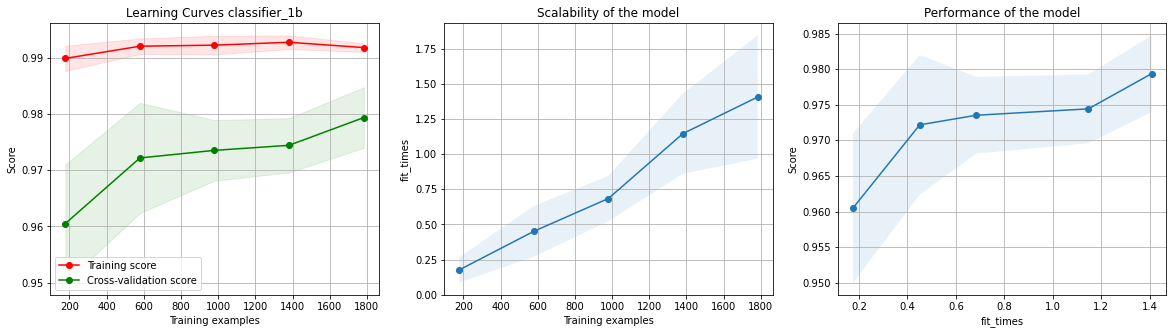

In [ ]:
plot_learning_curve(loaded_final_model_features, 'Learning Curves classifier_1b', X_train_features, y_train)

In [ ]:
print('Precision on train set is {:.4f}'.format(loaded_final_model_features.score(X_train_features, y_train)))

Precision on train set is 0.9924


#### Evaluate model on test datset

In [ ]:
def featurizerPipeline(text):
  test_features, feature_names = featurizer.fit_transform(text)
  predictions = loaded_final_model_features.predict(test_features)
  return predictions

In [ ]:
y_test_pred = featurizerPipeline(X_test)

In [ ]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.95      0.91      0.93       290

    accuracy                           0.98      2229
   macro avg       0.97      0.95      0.96      2229
weighted avg       0.98      0.98      0.98      2229



In [ ]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.95      0.91      0.93       290

    accuracy                           0.98      2229
   macro avg       0.97      0.95      0.96      2229
weighted avg       0.98      0.98      0.98      2229



In [ ]:
print('Precision for test set is {:.4f}'.format(precision_score(y_test, y_test_pred)))

Precision for test set is 0.9464


In [ ]:
print('ROC_AUC is {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

ROC_AUC is 0.9518


From the learning curve, we infer that Featurizer pipeline seem to perform better than sparse embeddings in learning the true relationship with increase in sample size owing to the following additional features. After feature transformation, Precision on train set is 0.9924 and test set is 0.9464 whereas auc is 0.9518. 

To distinguish spam from non-spam messages have added additional features as follows to featurizer
* count_words_with_all_capitals - For promotional offers so as to gain attention, spammers might as well use fully capitalized words
* symbols_count - symbol pos tags are used to capture symbols. Spammers tend to use exclammations as terminators or currency symbols for lotteries, job vacancies etc. Similarly non-spammers might use emoticons for casual messaging
* count_misspelled - Can be attributes of both spammers and non-spammers and predominantly spammers. So this is an important attribute as well
*'count_words','count_characters','count_characters_no_space','avg_word_length',
 'count_digits','count_numbers','noun_count','aux_count','verb_count',       'adj_count','symbols_count','ner'




**Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline**
* Used TF_IDF vectorizer for sparse embeddings
* Featurization
* Used Weighted XGBoost Classifier as ML Model to address class imbalance

In [ ]:
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', lower=True, remove_stop=True, remove_punct=True, remove_url=True, lammetize=True).transform(X_train)

In [ ]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [ ]:
X_train_features, feature_names  = featurizer.fit_transform(X_train)

In [ ]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned, columns =['cleaned_text']), 
                           pd.DataFrame(X_train_features, columns=feature_names)),axis =1)

In [ ]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,count_mispelled,count_words_with_all_capitals,noun_count,aux_count,verb_count,adj_count,symbols_count,ner
0,parent kidz friend n colleague scream surprise...,20.0,104.0,85.0,4.250000,0.0,0.0,2.0,3.0,1.0,6.0,1.0,2.0,1.0,0.0
1,oh rite im best mate pete go 4 week+ 2geva lon...,26.0,115.0,90.0,3.461538,2.0,2.0,1.0,26.0,0.0,9.0,1.0,2.0,1.0,0.0
2,wake 4 afternoon sup,9.0,43.0,35.0,3.888889,1.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0
3,sound good post,5.0,26.0,22.0,4.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
4,prob hon u doinat mo,8.0,32.0,25.0,3.125000,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0


In [ ]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cleaned_text                   2229 non-null   object 
 1   count_words                    2229 non-null   float64
 2   count_characters               2229 non-null   float64
 3   count_characters_no_space      2229 non-null   float64
 4   avg_word_length                2229 non-null   float64
 5   count_digits                   2229 non-null   float64
 6   count_numbers                  2229 non-null   float64
 7   count_mispelled                2229 non-null   float64
 8   count_words_with_all_capitals  2229 non-null   float64
 9   noun_count                     2229 non-null   float64
 10  aux_count                      2229 non-null   float64
 11  verb_count                     2229 non-null   float64
 12  adj_count                      2229 non-null   f

In [ ]:
subset = X_train_final[0:10]

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()),                     
                        ]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)),                     
                        ]) 

In [ ]:
sparse_features.fit_transform(subset.iloc[:,1:])

<10x14 sparse matrix of type '<class 'numpy.float64'>'
	with 87 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.fit_transform(subset.iloc[:,0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [ ]:
# Use vectorizer for cleaned_text and sparse_features for everything else
# Combined_Features to combine text with non text data
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [ ]:
test = combined_features.fit_transform(subset)

In [ ]:
classifier_1c = Pipeline([('combined_features',  combined_features),
                         ('classifier', XGBClassifier()),])

In [ ]:
weights    = [1, 10, 25, 50, 75, 99, 100, 1000]

param_dist_classifier_1c = {
              "classifier__max_depth": [2,3,4,5,6],
              "classifier__learning_rate":[0.01,0.02,0.03,0.05,0.1,0.3,0.5],
              "classifier__reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
              "classifier__gamma":[i/10.0 for i in range(0,5)],
              "classifier__n_estimators":[100,500,700,1000],
              "classifier__scale_pos_weight":weights,
              'classifier__max_delta_step': range(1,10,1),              
              'combined_features__tfidf__tfidf__ngram_range': ((1, 1), (1, 2), (1,3)),
              'combined_features__tfidf__tfidf__max_features': [None, 500, 800, 1000, 1500, 2000],
              'combined_features__tfidf__tfidf__max_df': [0.8, 0.6, 0.4, 0.2]
              }

In [ ]:
randomized_classifier_1c = RandomizedSearchCV(estimator=classifier_1c, param_distributions=param_dist_classifier_1c, cv = 5, scoring="precision", n_jobs=-1)

In [ ]:
randomized_classifier_1c.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(max_features=5))]),
                                                                               'cleaned_text')])),
                                             ('classifier', XGBClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__gamma': [0.0, 0.1, 0.2,
                                                              0.3...
            

In [ ]:
print("Best cross-validation score: {:.2f}".format(randomized_classifier_1c.best_score_))
print("\nBest parameters: ", randomized_classifier_1c.best_params_)
print("\nBest estimator: ", randomized_classifier_1c.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'combined_features__tfidf__tfidf__ngram_range': (1, 3), 'combined_features__tfidf__tfidf__max_features': 500, 'combined_features__tfidf__tfidf__max_df': 0.8, 'classifier__scale_pos_weight': 1, 'classifier__reg_alpha': 0.01, 'classifier__n_estimators': 700, 'classifier__max_depth': 4, 'classifier__max_delta_step': 4, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.4}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.8,
                                                                                   max_features=500,
                       

In [ ]:
file_model_combined = model_folder / 'spam_combined_model.pkl'

In [ ]:
joblib.dump(randomized_classifier_1c.best_estimator_, file_model_combined)

['/content/drive/MyDrive/NLP/models/arul_prec_spam_combined_model.pkl']

In [ ]:
loaded_model_combined = joblib.load(file_model_combined)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

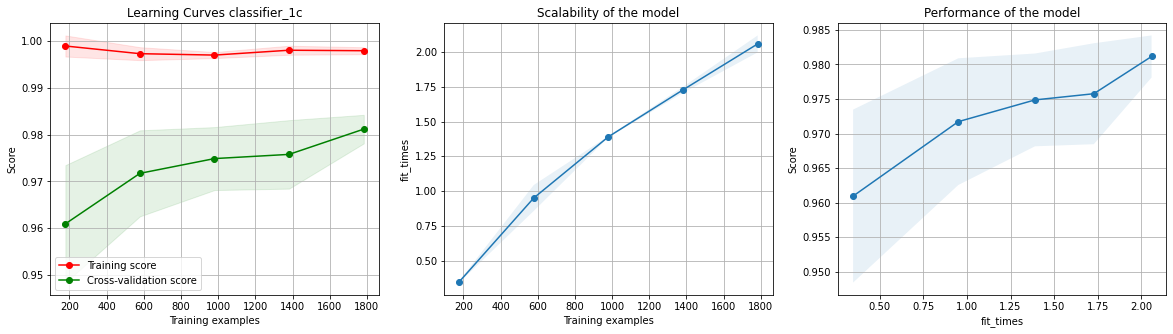

In [ ]:
plot_learning_curve(loaded_model_combined, 'Learning Curves classifier_1c', X_train_final, y_train)

In [ ]:
# Precision on Train data set
random_classifier_combined = loaded_model_combined.score(X_train_final, y_train)
print(f'Precision on train set  is {random_classifier_combined}')

Precision on train set  is 0.996859578286227


**Evaluate model on test dataset**


In [ ]:
def combinedSparseEmbFeaturizerPipeline(text):
  X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', lower=True, remove_stop=True, remove_punct=True, remove_url=True, lammetize=True).transform(text)
  X_features, feature_names  = featurizer.fit_transform(text)
  X_final = pd.concat((pd.DataFrame(X_test_cleaned, columns =['cleaned_text']), 
                           pd.DataFrame(X_features, columns=feature_names)),axis =1)
  
  predictions = loaded_model_combined.predict(X_final)
  return predictions

In [ ]:
y_test_pred = combinedSparseEmbFeaturizerPipeline(X_test)

In [ ]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.97      0.92      0.95       290

    accuracy                           0.99      2229
   macro avg       0.98      0.96      0.97      2229
weighted avg       0.99      0.99      0.99      2229



In [ ]:
from sklearn.metrics import precision_score
print('Precision for test dataset is {:.4f}'.format(precision_score(y_test, y_test_pred)))

Precision for test dataset is 0.9709


In [ ]:
print('ROC_AUC is {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

ROC_AUC is 0.9583


From the learning curve, we infer that Sparse embeddings combined with feature transformation pipeline performs better of all in learning the true relationship with increase in sample size. However it seems to suffer from overfitting. Precision on train set is 0.9968 and test set is 0.9709 whereas auc is 0.9583.

## **Analysis Summary**

**Sparse Embeddings Pipeline:**
> From its respective learning curve, we infer that Sparse embeddings pipeline seem to perform decently in learning the true relationship with increase in sample size. This tells us that spammers tend to use some unique words compared to non-spammers. Precision on train set is 0.9843 and test set is 0.9559 whereas auc is 0.8716. 

**Featurizer Pipeline**
> From its respective learning curve, we infer that Featurizer pipeline seem to perform better than sparse embeddings in learning the true relationship with increase in sample size owing to the following additional features. Featured Precision on train set is 0.9924 and test set is 0.9464 whereas auc is 0.9518. 

> To distinguish spam from non-spam messages have added additional features as follows to featurizer
* count_words_with_all_capitals - For promotional offers so as to gain attention, spammers might as well use fully capitalized words
* symbols_count - symbol pos tags are used to capture symbols. Spammers tend to use exclammations as terminators or currency symbols. Similarly non-spammers might use emoticons as casual messaging
* count_misspelled - Can be attributes of both spammers and non-spammers but this is an important attribute as well
*count_words,count_characters,count_characters_no_space,avg_word_length,
 count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,symbols_count,ner

**Combined Pipeline:**
> From the learning curve, we infer that Sparse embeddings combined with feature transformation pipeline performs better of all in learning the true relationship with increase in sample size. Precision on train set is 0.9968 and test set is 0.9709 whereas auc is 0.9583.

**Overall, Combined Pipeline is the chosen pipeline since in comparison it not only offers a better precision score but also gives a better auc of 0.9583. Moreover one common problem in all the three is overfitting which we shall address in the final pipeline by adding more data by training with entire dataset and also by hyper-param tuning**


